In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from functools import reduce
import math

In [3]:
# Biggest wealth transfer occurs if poorest 51% take wealth of richest 49%,
# This is the system dynamics
def find_winners_and_losers(w, weights=None):
    if weights is None:
        n = len(w)
        median = n // 2
        w = sorted(w)
        return w[:median + 1], w[median + 1:]
    else:
        sorted_w, sorted_weights = zip(*sorted(zip(w, weights)))

        s = 0
        for i in range(len(sorted_weights)):
            new_s = s + sorted_weights[i]
            if s < 0.5 and new_s > 0.5:
                break_index = i + 1
            s = new_s
        return list(sorted_w[:break_index]), list(sorted_w[break_index:])

def voting_iteration(w0, use_weights=False):
    w = sorted(w0)

    if use_weights:
        s = sum(w)
        tau = [i/s for i in w]
        w_win, w_lose = find_winners_and_losers(w, tau)
    else:
        w_win, w_lose = find_winners_and_losers(w, None)

    # This is a redistribution policy, parametrize it
    # Another redistribution policy is where only one person
    # gets all the wealth of the losers
    wealth_limit = w_win[-1]
    n_win = len(w_win)
    n_lose = len(w_lose)
    s_lose = sum(w_lose)
    
    # Add uniformly
    to_add = s_lose/n_win
    
    # Count the number of winners having wealth equal to wealth_limit 
    n_swing = sum([i == wealth_limit for i in w_win])
    n_swings_so_far = 0

    for i in range(len(w0)):
        # If i is poor
        if w0[i] < wealth_limit:
            w0[i] += to_add

        # Else if i is rich
        elif w0[i] > wealth_limit:
            w0[i] = 0
        
        # Else, if he's on the margin
        else:
            # Count how many wealth_limit people we've seen so far
            n_swings_so_far += 1

            if n_swings_so_far > n_swing:
                w0[i] = 0
            else:
                w0[i] += to_add

    return w0, s_lose

def save_results(w0, n_iterations=50, use_weights=False):
    n = len(w0)
    results = np.zeros(shape=(n_iterations, n), dtype=float)
    transfers = np.zeros(n_iterations)
    
    w = w0
    for i in range(n_iterations):
        w, transfer = voting_iteration(w, use_weights)
        results[i] = w
        transfers[i] = transfer
    
    return results, transfers
    

# w = [1, 2, 3, 4, 5, 40, 0.1, 0.1, 2.5, 5.5, 7, 2.3, 8, 10, 20, 25, 4, 4, 3]
w = np.random.pareto(2, (100))
r, t = save_results(w, 50, use_weights=False)
r2, t2 = save_results(w, 50, use_weights=True)

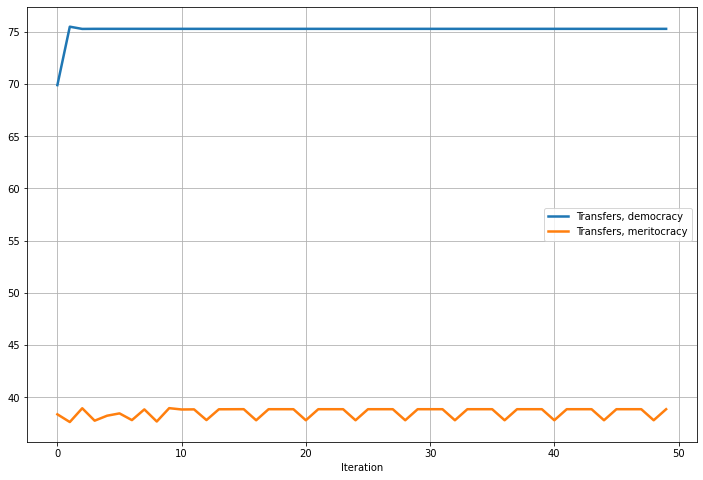

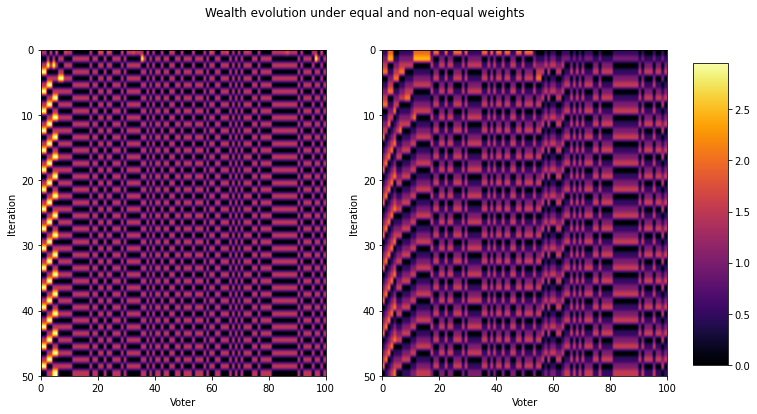

In [4]:
plt.figure(figsize=(12, 8), facecolor='white')
plt.plot(t, label='Transfers, democracy', linewidth=2.5)
plt.plot(t2, label='Transfers, meritocracy', linewidth=2.5)

plt.xlabel("Iteration")
plt.legend()
plt.grid(True)

# plt.figure(figsize=(20, 8), facecolor='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), facecolor='white')

# find minimum of minima & maximum of maxima
minmin = np.min([np.min(r), np.min(r2)])
maxmax = np.max([np.max(r), np.max(r2)])

im1 = axes[0].imshow(r, vmin=minmin, vmax=maxmax,
                     extent=(0, 100, 50, 0), aspect='auto', cmap='inferno')
axes[0].set(xlabel="Voter", ylabel="Iteration")
axes[1].set(xlabel="Voter", ylabel="Iteration")
im2 = axes[1].imshow(r2, vmin=minmin, vmax=maxmax,
                     extent=(0,100,50,0), aspect='auto', cmap='inferno')

plt.suptitle("Wealth evolution under equal and non-equal weights")
# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)



In [8]:
m1 = np.array(r[-1])
m2 = np.array(r2[-1])

def entropy(x):
    x = x + 1e-7
    p = x/x.sum()
    return -(p * np.log2(p)).sum()

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

def describe(x):
    print("mean", x.mean(), "std", x.std(), "entropy", entropy(x), "gini", gini(x))

print("Democracy equilibrium:")
describe(m1)

print("Meritocracy equilibrium:")
describe(m2)

# Meritocracy is more equal, has lower gini index

Democracy equilibrium:
mean 1.0660844935709173 std 1.0815330683514408 entropy 5.6524499430961495 gini 0.5084905183407176
Meritocracy equilibrium:
mean 1.0660844935709175 std 0.8014470422156118 entropy 6.09878173097966 gini 0.4203126261809564


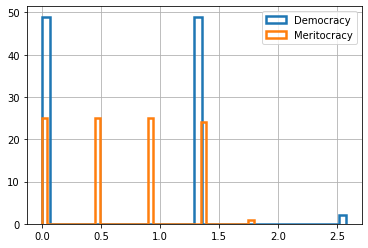

In [24]:
plt.hist(r[-1], bins=40, histtype='step', linewidth=2.5, label='Democracy')
plt.hist(r2[-1], bins=40, histtype='step', linewidth=2.5, label='Meritocracy')
plt.legend()
plt.grid(True)

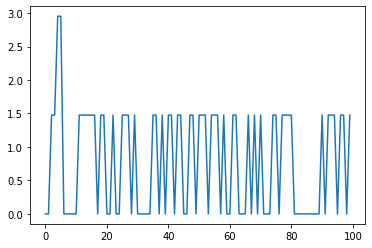

In [10]:
plt.plot(r[-1])

## Experiment 2

In [9]:
# Biggest wealth transfer occurs if poorest 51% take wealth of richest 49%,
# This is the system dynamics
def find_winners_and_losers(w, weights=None):
    n = len(w)
    if weights is None:
        weights = [1/n for _ in range(n)]
    sorted_w, sorted_weights, sorted_inds = zip(*sorted(zip(w, weights, list(range(n)))))

    s = 0
    for i in range(len(sorted_weights)):
        new_s = s + sorted_weights[i]
        if s <= 0.5 and new_s > 0.5:
            break_index = i + 1
        s = new_s
    return list(sorted_w[:break_index]), list(sorted_w[break_index:]), sorted_inds

def voting_iteration(w0_init, use_weights=False):
    w0 = deepcopy(w0_init)

    if use_weights:
        s = sum(w0)
        tau = [i/s for i in w]
        w_win, w_lose, sorted_indices = find_winners_and_losers(w0, tau)
    else:
        w_win, w_lose, sorted_indices = find_winners_and_losers(w0, None)
    
    # This is a redistribution policy, parametrize it
    # Another redistribution policy is where only one person
    # gets all the wealth of the losers
    wealth_limit = w_win[-1]
    n_win = len(w_win)
    n_lose = len(w_lose)
    s_lose = sum(w_lose)

    # Add uniformly
    to_add = s_lose/n_win

    # Count the number of winners having wealth equal to wealth_limit 
    n_swing = sum([i == wealth_limit for i in w_win])
    n_swings_so_far = 0

    for i in range(len(w0)):
        # If i is poor
        if w0[i] < wealth_limit:
            w0[i] += to_add

        # Else if i is rich
        elif w0[i] > wealth_limit:
            w0[i] = 0
        
        # Else, if he's on the margin
        else:
            # Count how many wealth_limit people we've seen so far
            n_swings_so_far += 1

            if n_swings_so_far > n_swing:
                w0[i] = 0
            else:
                w0[i] += to_add
    
    assert math.isclose(sum(w0), sum(w0_init), rel_tol=1e-6)
    return w0, s_lose

In [40]:
def save_results(w0, n_iterations=50, use_weights=False):
    n = len(w0)
    results = np.zeros(shape=(n_iterations, n), dtype=float)
    transfers = np.zeros(n_iterations, dtype=float)
    
    w = deepcopy(w0)
    for i in range(n_iterations):
        w, transfer = voting_iteration(w, use_weights)
        results[i] = w
        transfers[i] = transfer
    
    return results, transfers
    

# w = [1, 2, 3, 4, 5, 40, 0.1, 0.1, 2.5, 5.5, 7, 2.3, 8, 10, 20, 25, 4, 4, 3]
np.random.seed(42)
w = np.random.pareto(2, (100)).tolist()
r, t = save_results(w, 100, use_weights=False)
r2, t2 = save_results(w, 100, use_weights=True)

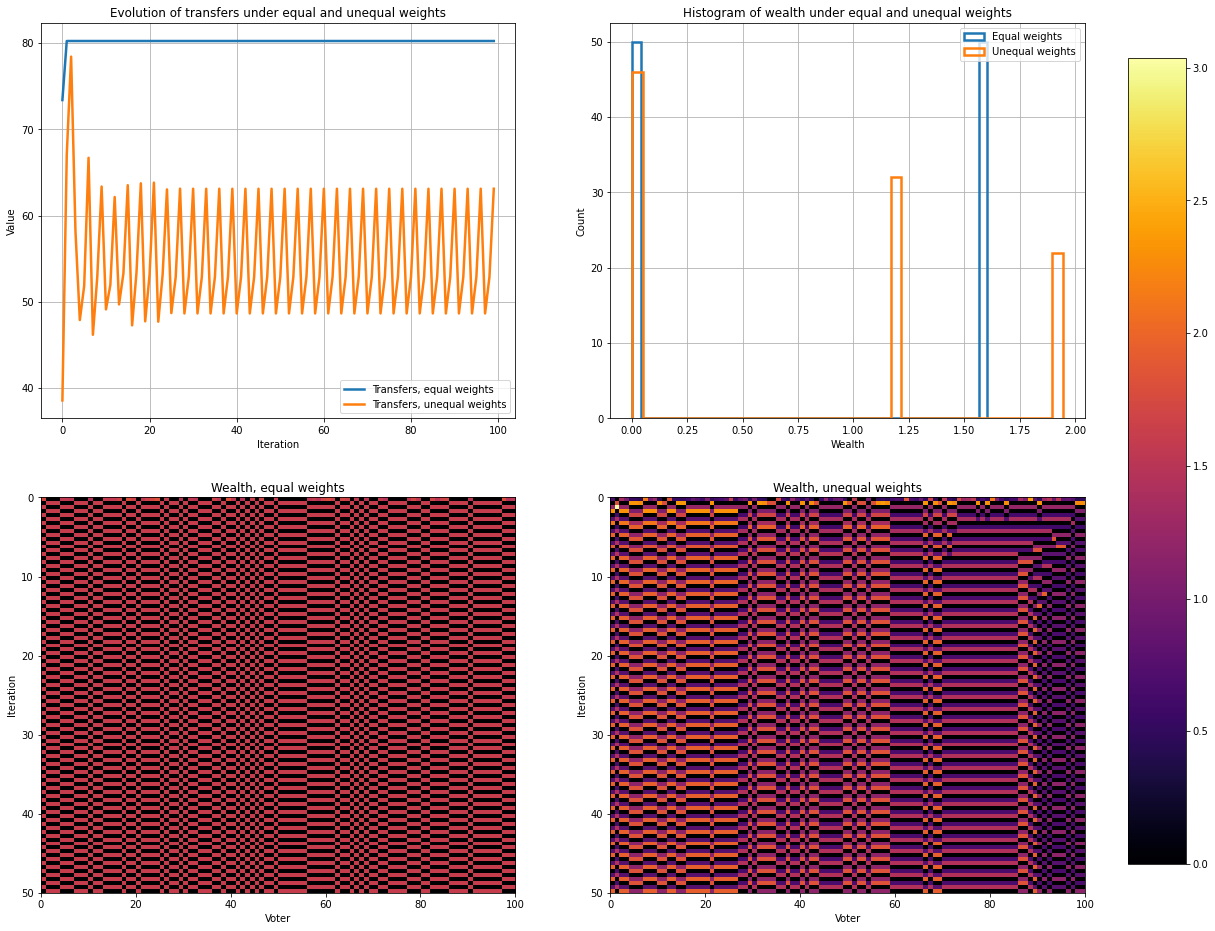

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 16), facecolor='white')

axes[0, 0].plot(t, label='Transfers, equal weights', linewidth=2.5)
axes[0, 0].plot(t2, label='Transfers, unequal weights', linewidth=2.5)
axes[0, 0].set(xlabel="Iteration", ylabel="Value", title="Evolution of transfers under equal and unequal weights")
axes[0, 0].grid()
axes[0, 0].legend()


axes[0, 1].hist(r[-1], bins=40, histtype='step', linewidth=2.5, label='Equal weights')
axes[0, 1].hist(r2[-1], bins=40, histtype='step', linewidth=2.5, label='Unequal weights')
axes[0, 1].grid()
axes[0, 1].legend()
axes[0, 1].set(xlabel="Wealth", ylabel="Count", title="Histogram of wealth under equal and unequal weights")


# plt.figure(figsize=(20, 8), facecolor='white')

# find minimum of minima & maximum of maxima
minmin = np.min([np.min(r), np.min(r2)])
maxmax = np.max([np.max(r), np.max(r2)])

im1 = axes[1, 0].imshow(r, vmin=minmin, vmax=maxmax,
                     extent=(0, 100, 50, 0), aspect='auto', cmap='inferno')
axes[1, 0].set(xlabel="Voter", ylabel="Iteration", title="Wealth, equal weights")
axes[1, 1].set(xlabel="Voter", ylabel="Iteration", title="Wealth, unequal weights")
im2 = axes[1, 1].imshow(r2, vmin=minmin, vmax=maxmax,
                     extent=(0,100,50,0), aspect='auto', cmap='inferno')

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)
plt.savefig("weighted_voting_simulation.svg", dpi=150, bbox_inches='tight')

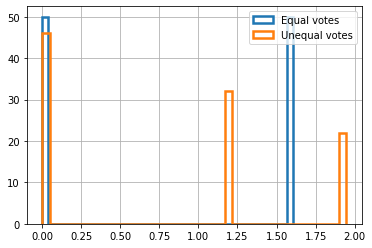

In [24]:
# Weighted voting transfers have periodicity 3, equal voting transfers have periodicity 1
# Weighted voting wealths have periodicity 3, equal voting wealths have periodicity 2

plt.hist(r[-1], bins=40, histtype='step', linewidth=2.5, label='Equal votes')
plt.hist(r2[-1], bins=40, histtype='step', linewidth=2.5, label='Unequal votes')
plt.legend()
plt.grid(True)

In [28]:
voting_iteration(r2[-1], True)

(array([0.        , 0.6668321 , 0.        , 0.        , 1.83584639,
        1.83584639, 1.83584639, 0.        , 0.        , 0.        ,
        1.83584639, 1.83584639, 0.        , 0.        , 1.83584639,
        1.83584639, 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.83584639, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.6668321 , 0.6668321 , 1.83584639,
        0.6668321 , 1.83584639, 1.83584639, 1.83584639, 1.83584639,
        0.6668321 , 0.6668321 , 1.83584639, 0.6668321 , 0.6668321 ,
        1.83584639, 0.6668321 , 1.83584639, 1.83584639, 0.6668321 ,
        0.6668321 , 0.6668321 , 0.6668321 , 0.6668321 , 1.83584639,
        1.83584639, 0.6668321 , 1.83584639, 1.83584639, 0.6668321 ,
        1.83584639, 1.83584639, 1.83584639, 1.83584639, 0.6668321 ,
        0.6668321 , 0.6668321 , 0.6668321 , 0.6668321 , 0.6668321 ,
        0.6668321 , 0.        , 0.6668321 , 0.        , 0.        ,
        0.6668321 , 0.6668321 , 0.6668321 , 0.66

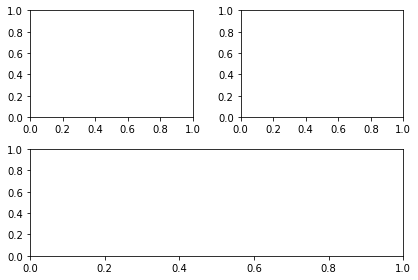

In [34]:
fig, axs = plt.subplots(ncols=2, nrows=2)

gs = axs[0, 1].get_gridspec()
# remove the underlying axes

for ax in axs[-1, :]:
    ax.remove()

axbig = fig.add_subplot(gs[1, :])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')

fig.tight_layout()

plt.show()

In [38]:
axbig

<AxesSubplot:>